### Ridge Regression Demand Forecasting Project

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1. Load dataset ===
df = pd.read_csv("sales_data.csv")

# === 2. Convert Date ===
df['Date'] = pd.to_datetime(df['Date'])

#### Unique Time Series Identification

Each time series is uniquely identified by a combination of **Store ID** and **Product ID**.

This is necessary because the dataset includes multiple products across multiple stores, as shown below:

| Store ID | Product ID |
|----------|------------|
| S001     | P0001      |
| S001     | P0002      |
| S002     | P0001      |
| S002     | P0002      |

Each row represents a distinct product-store combination, which forms a separate time series.

In [41]:
# === 3. Create composite ID ===
df['Store_Product_ID'] = df['Store ID'].astype(str) + '_' + df['Product ID'].astype(str)

#### Ensures lag and rolling computations are applied in time order within each product-store.

In [42]:
# === 4. Sort for lag features ===
df = df.sort_values(by=['Store_Product_ID', 'Date'])

#### Creates historical features (lags) and 7-day/14-day rolling averages to capture trends and seasonality.

In [43]:
# === 5. Lag and rolling features ===
df['Lag_1_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1)
df['Lag_2_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(2)
df['Lag_3_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(3)
df['Rolling_7_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=7).mean()
df['Rolling_14_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=14).mean()

#### Binary features that help the model learn from supply-demand imbalances.

In [44]:
# === 6. Backorder and stockout risk ===
df['Backorder'] = (df['Units Ordered'] > df['Units Sold']).astype(int)
df['Stockout_Risk'] = (df['Inventory Level'] < df['Units Ordered']).astype(int)

#### Extracts time-based signals, including cyclical patterns like seasonal sinusoids for DayOfYear.

In [45]:
# === 7. Date features + seasonality ===
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

#### Transforms regions, weather, category, and seasonality into numeric columns the model can use.

In [46]:
# === 8. Encode categoricals ===
df = pd.get_dummies(df, columns=['Region', 'Weather Condition', 'Seasonality', 'Category'], drop_first=True)

#### Combines features that interact logically

In [47]:
# === 9. Feature interactions ===
df['Price_Discount'] = df['Price'] * df['Discount']
df['Price_vs_Competitor'] = df['Price'] - df['Competitor Pricing']
df['Promo_Discount'] = df['Promotion'] * df['Discount']

#### Removes rows with missing values after lagging and rolling.

In [48]:
# === 10. Drop rows with NaNs ===
print(f"The number of rows before dropping rows with NaNs : {len(df)}")
df.dropna(inplace=True)
print(f"The number of rows after dropping rows with NaNs : {len(df)}")

The number of rows before dropping rows with NaNs : 76000
The number of rows after dropping rows with NaNs : 74600


#### Demand Standardization Within Each Time Series

This part of the code:

```python
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)
```

is standardizing the demand within each `Store_Product_ID` group.

For each unique combination of store and product (e.g., `"S001_P0001"`), it applies the following transformation to the `Demand` values:

```
Demand_scaled = (Demand - mean) / std_deviation
```

Where:

- `m` is the **mean** demand for that `Store_Product_ID`
- `s` is the **standard deviation** of demand for that `Store_Product_ID`

---

##### Why This is Done

There are three key reasons for this standardization:

---

##### 1. Fair Comparison Across Groups

- Each `Store_Product_ID` can have very different sales volumes.
- A high-volume combination (e.g., `S001_P0001`) might have an average demand of 500, while a low-volume one (e.g., `S003_P0009`) might average 5.
- **Standardization ensures** the model learns **patterns**, not just magnitudes.

---

##### 2. Better Model Convergence

- Machine learning algorithms (especially those using gradient-based optimization like Ridge Regression) work better when features are on **similar scales**.
- Standardizing the target:
  - Helps the model converge **faster**
  - Prevents bias toward **large-valued outputs**

---

##### 3. Prevent Data Leakage

- Grouping by `Store_Product_ID` ensures that **no information leaks across different time series** (i.e., between store-product combinations).
- This is especially important in **time-series forecasting**.

---

##### Reversing the Standardization

Later, the standardized predictions are converted back to actual demand values:

```python
preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means
```

- This transforms the model's predicted standardized demand (`y_pred_scaled`) back to actual demand units using the **group-specific mean and standard deviation**.

---

##### Summary

This line below

- Scales demand to **zero mean and unit variance** within each time series (`Store_Product_ID`)
- Stabilizes training and enables the model to learn **relative patterns** more effectively
- Then unscales predictions to retrieve the **actual demand numbers**

In [49]:
# === 11. Normalize demand by composite ID ===
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)

#### Sets target (y) and predictors (X) for training.

In [50]:
# === 12. Set target and features ===
y = df['Demand_scaled']

feature_cols = [
    'Price', 'Discount', 'Competitor Pricing', 'Promotion', 'Inventory Level',
    'Units Ordered', 'Month', 'Day', 'Weekday', 'Quarter', 'DayOfYear', 'Is_Weekend',
    'Sin_DayOfYear', 'Cos_DayOfYear', 'Backorder', 'Stockout_Risk', 'Epidemic',
    'Lag_1_Demand', 'Lag_2_Demand', 'Lag_3_Demand', 'Rolling_7_Demand', 'Rolling_14_Demand',
    'Price_Discount', 'Price_vs_Competitor', 'Promo_Discount'
]

feature_cols += [col for col in df.columns if
                 col.startswith('Region_') or
                 col.startswith('Weather Condition_') or
                 col.startswith('Seasonality_') or
                 col.startswith('Category_')]

X = df[feature_cols]

#### TimeSeriesSplit

- This sets up time-aware cross-validation.
- Instead of randomly shuffling data, TimeSeriesSplit ensures that training data always precedes test data, which is crucial in time series forecasting.
- With n_splits=5, it creates 5 train/test splits that respect time order.

In [51]:
# === 13. TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)

#### RidgeCV Pipeline

1. ('poly', PolynomialFeatures(degree=2, include_bias=False))

- Expands your input features to include polynomial terms up to degree 2.
- If your features are [x1, x2], it adds terms like [x1², x2², x1*x2].
- include_bias=False avoids adding a column of ones.

2. ('scaler', StandardScaler())

- Standardizes features (zero mean, unit variance), which is important for regularized models like Ridge.

3. ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))

- Trains a Ridge Regression model.
- Uses cross-validation to find the best alpha (regularization strength) from the list [0.001, 0.01, 0.1, 1.0, 10.0].
- scoring='r2' means it selects the alpha that gives the best R² score.
- cv=tscv uses the TimeSeriesSplit defined earlier.

In [52]:
# === 14. RidgeCV Pipeline ===
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))
])

# === Trains the full pipeline with cross-validated Ridge regression.
pipeline.fit(X, y)

,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


#### Gets predictions, then reverts them from scaled units back to actual demand values.

In [53]:
# === 15. Prediction ===
y_pred_scaled = pipeline.predict(X)

##### Inverse Scale Predictions
- `preds_df`: a new DataFrame to hold actual and predicted values.
- `means` and `stdevs`: calculated per `Store_Product_ID`, used to reverse standardization.
- `y_pred`: transforms `y_pred_scaled` back to original demand scale using:

$$
y_{pred} = y_{pred\_scaled} \times \sigma + \mu
$$

In [54]:
# === 16. Inverse scale back to original demand ===
preds_df = df[['Store_Product_ID', 'Demand', 'Date']].copy()
preds_df['y_pred_scaled'] = y_pred_scaled

means = df.groupby('Store_Product_ID')['Demand'].transform('mean')
stdevs = df.groupby('Store_Product_ID')['Demand'].transform('std')

preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means

##### Add 95% Prediction Interval
- `residual_std`: standard deviation of the residuals (actual - predicted).
- Assumes residuals are normally distributed.
- Adds upper and lower bounds covering ~95% of expected variation:

$$
y_{upper} = y_{pred} + 1.96 \cdot \sigma
$$
$$
y_{lower} = y_{pred} - 1.96 \cdot \sigma
$$

In [55]:
# === Add 95% prediction interval ===
# === Uses standard deviation of residuals to create a confidence band (±1.96σ covers ~95%).
residual_std = (preds_df['Demand'] - preds_df['y_pred']).std()
preds_df['y_upper'] = preds_df['y_pred'] + 1.96 * residual_std
preds_df['y_lower'] = preds_df['y_pred'] - 1.96 * residual_std

#### Evaluation

In [56]:
# === 17. Evaluation ===
r2 = r2_score(preds_df['Demand'], preds_df['y_pred'])
mae = mean_absolute_error(preds_df['Demand'], preds_df['y_pred'])
rmse = np.sqrt(mean_squared_error(preds_df['Demand'], preds_df['y_pred']))
actual_std = preds_df['Demand'].std()

print(f"R² Score ( % variance explained ): {r2:.4f}")
print(f"MAE ( average absolute error ): {mae:.4f}")
print(f"RMSE ( error magnitude (in same units as demand) ): {rmse:.4f}")
print(f"Std Dev of Actual Demand: {actual_std:.4f}")
print(f"Std Dev of Residuals: {residual_std:.4f}")

R² Score ( % variance explained ): 0.6806
MAE ( average absolute error ): 20.2389
RMSE ( error magnitude (in same units as demand) ): 26.5680
Std Dev of Actual Demand: 47.0093
Std Dev of Residuals: 26.5682


#### Visual check for bias: residuals should be centered around 0 and evenly spread.

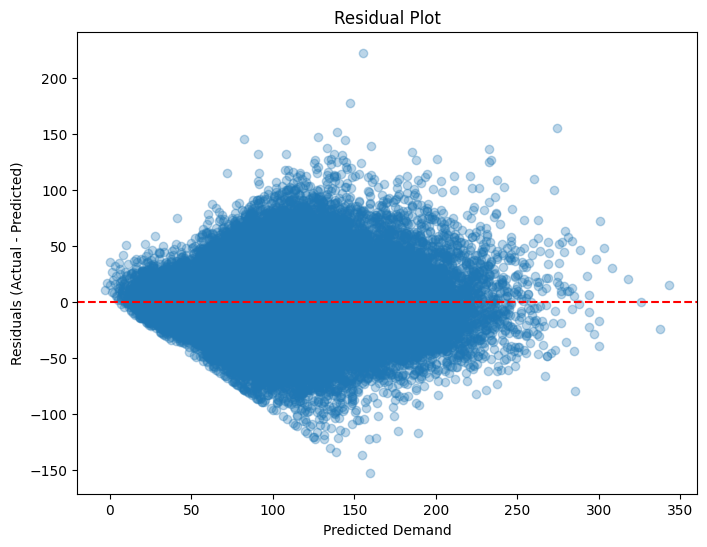

In [57]:
# === 18. Residual Plot ===
plt.figure(figsize=(8,6))
plt.scatter(preds_df['y_pred'], preds_df['Demand'] - preds_df['y_pred'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Demand")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

#### Actual vs Predicted Demand over time
#### Shaded area = 95% prediction interval

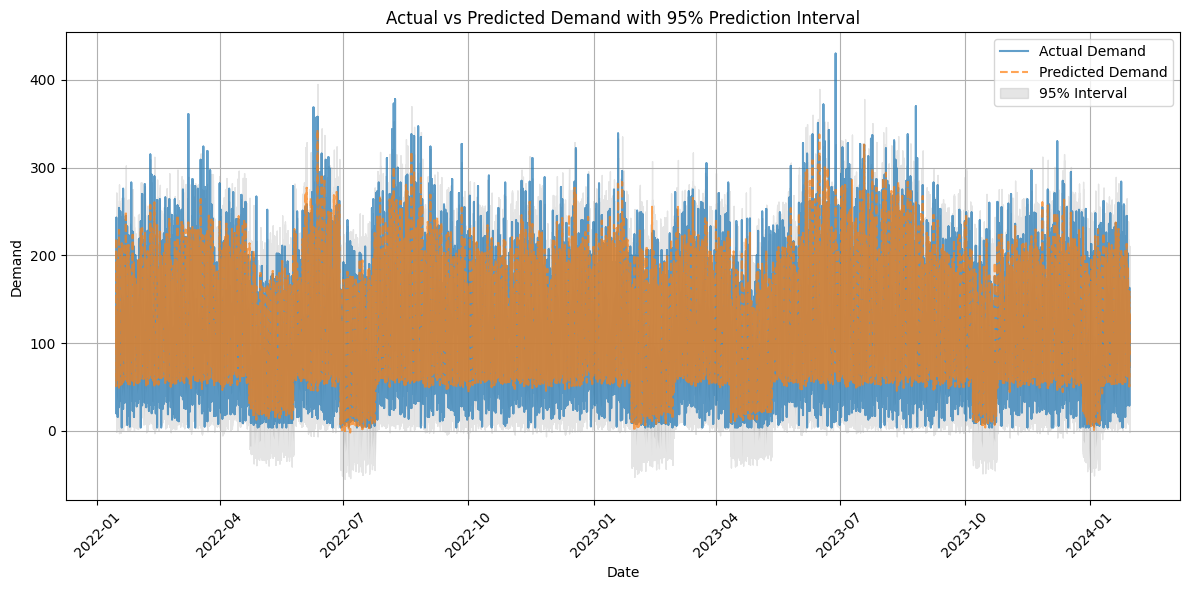

In [58]:
# === 19. Time Series Plot with Prediction Interval ===

preds_df = preds_df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(preds_df['Date'], preds_df['Demand'], label='Actual Demand', alpha=0.7)
plt.plot(preds_df['Date'], preds_df['y_pred'], label='Predicted Demand', linestyle='--', alpha=0.7)
plt.fill_between(preds_df['Date'], preds_df['y_lower'], preds_df['y_upper'], color='gray', alpha=0.2, label='95% Interval')
plt.title("Actual vs Predicted Demand with 95% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
# === Summary for Presentation ===
summary = """
📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: {:.4f}
MAE: {:.2f}
RMSE: {:.2f}
Std Dev of Actual Demand: {:.2f}
Std Dev of Residuals: {:.2f}

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales
""".format(r2, mae, rmse, actual_std, residual_std)

print(summary)



📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: 0.6806
MAE: 20.24
RMSE: 26.57
Std Dev of Actual Demand: 47.01
Std Dev of Residuals: 26.57

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales



In [67]:
# Set Holding & Shortage Cost Percentages

# Assume 2% monthly storage cost (or adjust as needed)
holding_rate = 0.02  # 2% of unit price per period

# Assume 25% of price is lost per unit short (e.g., profit margin)
shortage_rate = 0.25  # 25% of price

df['Holding Cost Per Unit'] = df['Price'] * holding_rate
df['Shortage Cost Per Unit'] = df['Price'] * shortage_rate

In [68]:
print(df[['Store_Product_ID', 'Price', 'Holding Cost Per Unit', 'Shortage Cost Per Unit']].head())

     Store_Product_ID  Price  Holding Cost Per Unit  Shortage Cost Per Unit
1400       S001_P0001  81.93                 1.6386                 20.4825
1500       S001_P0001  71.17                 1.4234                 17.7925
1600       S001_P0001  61.85                 1.2370                 15.4625
1700       S001_P0001  69.63                 1.3926                 17.4075
1800       S001_P0001  70.59                 1.4118                 17.6475


In [69]:
# Compute Surplus and Shortage Quantities

# Units over demand = surplus → used for holding cost
df['Surplus Units'] = (df['Inventory Level'] - df['Demand']).clip(lower=0)

# Units below demand = shortage → used for shortage cost
df['Shortage Units'] = (df['Demand'] - df['Inventory Level']).clip(lower=0)

In [71]:
# Calculate Holding and Shortage Costs

df['Holding Cost'] = df['Surplus Units'] * df['Holding Cost Per Unit']
df['Shortage Cost'] = df['Shortage Units'] * df['Shortage Cost Per Unit']
df['Total Cost'] = df['Holding Cost'] + df['Shortage Cost']

In [72]:
print(df[['Date', 'Store_Product_ID', 'Inventory Level', 'Demand',
          'Surplus Units', 'Shortage Units',
          'Holding Cost', 'Shortage Cost', 'Total Cost']].head())

           Date Store_Product_ID  Inventory Level  Demand  Surplus Units  \
1400 2022-01-15       S001_P0001              180     175              5   
1500 2022-01-16       S001_P0001               54     126              0   
1600 2022-01-17       S001_P0001              287     102            185   
1700 2022-01-18       S001_P0001              512     102            410   
1800 2022-01-19       S001_P0001              411     123            288   

      Shortage Units  Holding Cost  Shortage Cost  Total Cost  
1400               0        8.1930           0.00      8.1930  
1500              72        0.0000        1281.06   1281.0600  
1600               0      228.8450           0.00    228.8450  
1700               0      570.9660           0.00    570.9660  
1800               0      406.5984           0.00    406.5984  


                  Holding Cost  Shortage Cost   Total Cost
Store_Product_ID                                          
S003_P0015         604029.5918     95018.0400  699047.6318
S002_P0014         599900.9386     58776.8825  658677.8211
S003_P0018         583042.3856     31288.8450  614331.2306
S005_P0012         547458.7592     30101.2725  577560.0317
S002_P0005         530541.6760     20077.8625  550619.5385


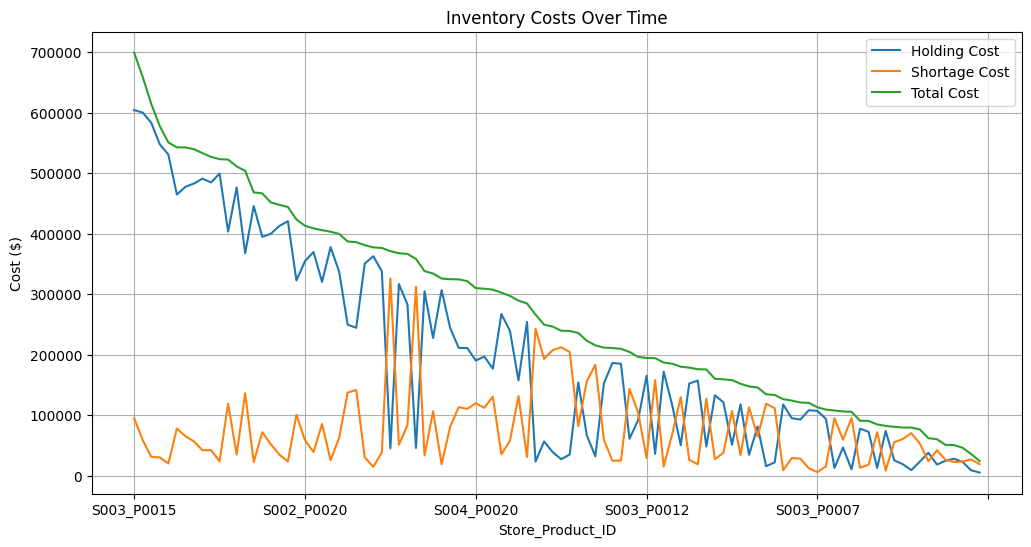

In [73]:
# Group by Store_Product_ID

cost_by_product = df.groupby('Store_Product_ID')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum().sort_values('Total Cost', ascending=False)

print(cost_by_product.head())

cost_by_product.plot(figsize=(12,6), title='Inventory Costs Over Time')
plt.ylabel('Cost ($)')
plt.grid(True)
plt.show()

In [74]:
# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Daily trend
cost_by_date = df.groupby('Date')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum()

# Optional: Monthly trend
df['Month'] = df['Date'].dt.to_period('M')
cost_by_month = df.groupby('Month')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum()

print(cost_by_month.tail())

         Holding Cost  Shortage Cost    Total Cost
Month                                             
2023-09   817310.6238    277407.1100  1.094718e+06
2023-10   722671.2996    215964.7975  9.386361e+05
2023-11   786097.0238    301757.5050  1.087855e+06
2023-12   883841.7874    335137.2425  1.218979e+06
2024-01   749789.6852    309493.7475  1.059283e+06


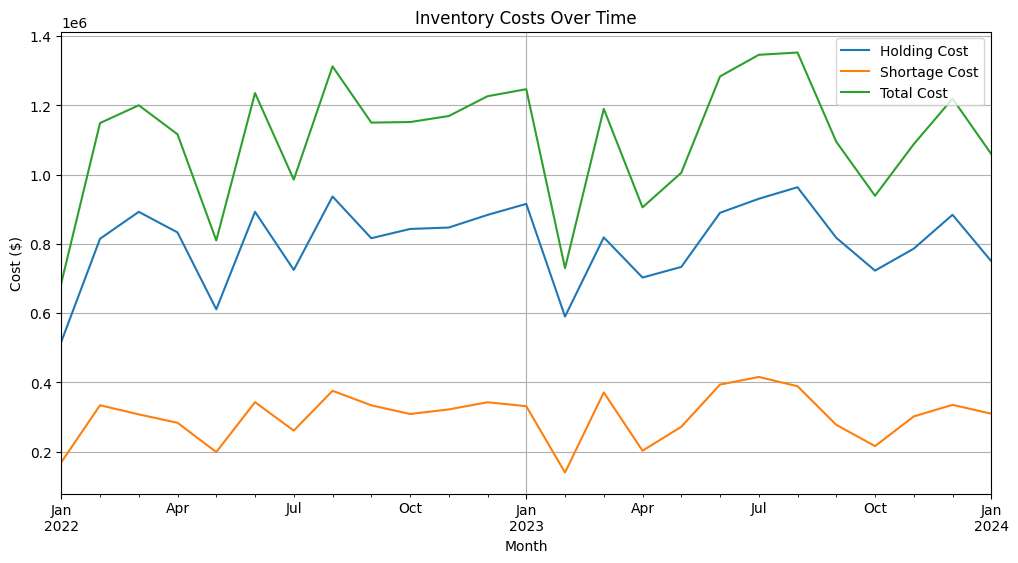

In [75]:
import matplotlib.pyplot as plt

# Plot total cost over time
cost_by_month.plot(figsize=(12,6), title='Inventory Costs Over Time')
plt.ylabel('Cost ($)')
plt.grid(True)
plt.show()

In [76]:
cost_by_store = df.groupby('Store ID')[['Holding Cost', 'Shortage Cost', 'Total Cost']].sum().sort_values('Total Cost', ascending=False)

print(cost_by_store.head())

          Holding Cost  Shortage Cost    Total Cost
Store ID                                           
S003      4.623293e+06   1.633134e+06  6.256428e+06
S002      4.673340e+06   1.518118e+06  6.191459e+06
S001      3.621262e+06   1.500964e+06  5.122226e+06
S004      3.482154e+06   1.615847e+06  5.098001e+06
S005      3.713650e+06   1.265611e+06  4.979261e+06


In [77]:
from scipy.stats import norm

target_service_level = 0.95

# z-score for target service level
z = norm.ppf(target_service_level)

In [79]:
# Assuming you have these columns:
# 'Units Sold' = actual demand observed
# 'Demand' = forecasted demand (Ridge Regression predictions)

# Calculate forecast errors
df['Forecast Error'] = df['Units Sold'] - df['Demand']

# Calculate standard deviation of forecast error per product or store_product_id
forecast_error_sd = df.groupby('Store_Product_ID')['Forecast Error'].std().rename('Forecast_Error_SD')

# Join back to your main dataframe (or a separate dataframe for forecasting)
df = df.merge(forecast_error_sd, on='Store_Product_ID', how='left')

# Optional: fill missing std dev with some small number if needed
df['Forecast_Error_SD'] = df['Forecast_Error_SD'].fillna(0)

# print(df[['Store_Product_ID', 'Forecast Error', 'Forecast_Error_SD']].head())
print(df['Forecast_Error_SD'].isna().sum())

0


In [80]:
# Calculate safety stock
df['Safety Stock'] = z * df['Forecast_Error_SD']

# Calculate optimal inventory
df['Optimal Inventory'] = df['Demand'] + df['Safety Stock']

# If you want to round up to nearest integer
df['Optimal Inventory'] = df['Optimal Inventory'].apply(np.ceil)

# Preview
print(df[['Store_Product_ID', 'Demand', 'Forecast_Error_SD', 'Safety Stock', 'Optimal Inventory']].head())

  Store_Product_ID  Demand  Forecast_Error_SD  Safety Stock  Optimal Inventory
0       S001_P0001     175          18.807347     30.935333              206.0
1       S001_P0001     126          18.807347     30.935333              157.0
2       S001_P0001     102          18.807347     30.935333              133.0
3       S001_P0001     102          18.807347     30.935333              133.0
4       S001_P0001     123          18.807347     30.935333              154.0


In [81]:
from scipy.stats import norm

service_levels = [0.90, 0.95, 0.99]
z_scores = [norm.ppf(sl) for sl in service_levels]

results = []

for sl, z in zip(service_levels, z_scores):
    df[f'Safety Stock {int(sl*100)}%'] = z * df['Forecast_Error_SD']
    df[f'Optimal Inventory {int(sl*100)}%'] = df['Demand'] + df[f'Safety Stock {int(sl*100)}%']
    df[f'Optimal Inventory {int(sl*100)}%'] = df[f'Optimal Inventory {int(sl*100)}%'].apply(np.ceil)
    
    # Calculate surplus, shortage, and costs
    surplus = (df[f'Optimal Inventory {int(sl*100)}%'] - df['Demand']).clip(lower=0)
    shortage = (df['Demand'] - df[f'Optimal Inventory {int(sl*100)}%']).clip(lower=0)
    
    holding_cost = surplus * df['Holding Cost Per Unit']
    shortage_cost = shortage * df['Shortage Cost Per Unit']
    total_cost = holding_cost + shortage_cost
    
    # Save summary stats for this service level
    summary = {
        'Service Level': sl,
        'Average Safety Stock': df[f'Safety Stock {int(sl*100)}%'].mean(),
        'Average Optimal Inventory': df[f'Optimal Inventory {int(sl*100)}%'].mean(),
        'Total Holding Cost': holding_cost.sum(),
        'Total Shortage Cost': shortage_cost.sum(),
        'Total Cost': total_cost.sum()
    }
    results.append(summary)

In [82]:
results_df = pd.DataFrame(results)
print(results_df)

   Service Level  Average Safety Stock  Average Optimal Inventory  \
0           0.90             32.311552                 136.991153   
1           0.95             41.471428                 146.121153   
2           0.99             58.653833                 163.311153   

   Total Holding Cost  Total Shortage Cost    Total Cost  
0        3.107405e+06                  0.0  3.107405e+06  
1        3.972754e+06                  0.0  3.972754e+06  
2        5.594813e+06                  0.0  5.594813e+06  


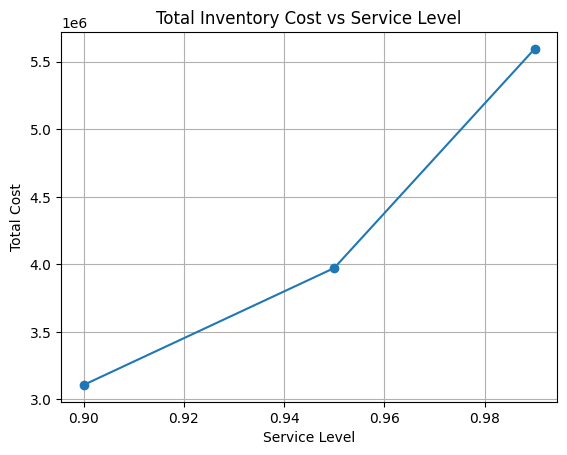

In [83]:
import matplotlib.pyplot as plt

plt.plot(results_df['Service Level'], results_df['Total Cost'], marker='o')
plt.title('Total Inventory Cost vs Service Level')
plt.xlabel('Service Level')
plt.ylabel('Total Cost')
plt.grid(True)
plt.show()

In [84]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Example service levels to simulate
service_levels = [0.90, 0.95, 0.99]
z_scores = [norm.ppf(sl) for sl in service_levels]

# Prepare a DataFrame to collect results per Store_Product_ID and service level
all_results = []

for sl, z in zip(service_levels, z_scores):
    suffix = str(int(sl * 100))
    safety_stock_col = f'Safety_Stock_{suffix}'
    optimal_inv_col = f'Optimal_Inventory_{suffix}'
    holding_cost_col = f'Holding_Cost_{suffix}'
    shortage_cost_col = f'Shortage_Cost_{suffix}'
    total_cost_col = f'Total_Cost_{suffix}'

    # Calculate safety stock
    df[safety_stock_col] = z * df['Forecast_Error_SD']
    if df[safety_stock_col].isna().any():
        print(f'NaNs found in {safety_stock_col}')
        print(df.loc[df[safety_stock_col].isna(), ['Store_Product_ID', safety_stock_col]])

    # Calculate optimal inventory
    df[optimal_inv_col] = np.ceil(df['Demand'] + df[safety_stock_col])
    if df[optimal_inv_col].isna().any():
        print(f'NaNs found in {optimal_inv_col}')
        print(df.loc[df[optimal_inv_col].isna(), ['Store_Product_ID', optimal_inv_col, 'Demand', safety_stock_col]])

    # Calculate surplus and shortage
    surplus = (df[optimal_inv_col] - df['Demand']).clip(lower=0)
    shortage = (df['Demand'] - df[optimal_inv_col]).clip(lower=0)

    # Calculate holding cost
    df[holding_cost_col] = surplus * df['Holding Cost Per Unit']
    if df[holding_cost_col].isna().any():
        print(f'NaNs found in {holding_cost_col}')
        print(df.loc[df[holding_cost_col].isna(), ['Store_Product_ID', holding_cost_col, 'Holding Cost Per Unit', 'Demand']])

    # Calculate shortage cost
    df[shortage_cost_col] = shortage * df['Shortage Cost Per Unit']
    if df[shortage_cost_col].isna().any():
        print(f'NaNs found in {shortage_cost_col}')
        print(df.loc[df[shortage_cost_col].isna(), ['Store_Product_ID', shortage_cost_col, 'Shortage Cost Per Unit', 'Demand']])

    # Calculate total cost
    df[total_cost_col] = df[holding_cost_col] + df[shortage_cost_col]
    if df[total_cost_col].isna().any():
        print(f'NaNs found in {total_cost_col}')
        print(df.loc[df[total_cost_col].isna(), ['Store_Product_ID', total_cost_col, holding_cost_col, shortage_cost_col]])

    # # Aggregate results by Store_Product_ID
    # grouped = df.groupby('Store_Product_ID')[
    #     [holding_cost_col, shortage_cost_col, total_cost_col, optimal_inv_col, safety_stock_col]
    # ].mean()
    # grouped = grouped.reset_index()
    # grouped['Service Level'] = sl

    # all_results.append(grouped)
    grouped = df.groupby('Store_Product_ID')[
        [holding_cost_col, shortage_cost_col, total_cost_col, optimal_inv_col, safety_stock_col]
    ].mean().reset_index()

    # Rename columns to common names
    grouped = grouped.rename(columns={
        holding_cost_col: 'Holding_Cost',
        shortage_cost_col: 'Shortage_Cost',
        total_cost_col: 'Total_Cost',
        optimal_inv_col: 'Optimal_Inventory',
        safety_stock_col: 'Safety_Stock'
    })

    grouped['Service_Level'] = sl

    all_results.append(grouped)

# Combine all service levels into one DataFrame
# results_df = pd.concat(all_results)
results_df = pd.concat(all_results, ignore_index=True)

# Preview results for a few Store_Product_IDs
# print(results_df.head(10))
print(results_df['Service_Level'].unique())


[0.9  0.95 0.99]


In [85]:
print(results_df.columns)

Index(['Store_Product_ID', 'Holding_Cost', 'Shortage_Cost', 'Total_Cost',
       'Optimal_Inventory', 'Safety_Stock', 'Service_Level'],
      dtype='object')


/tmp/ipykernel_28090/2211477871.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


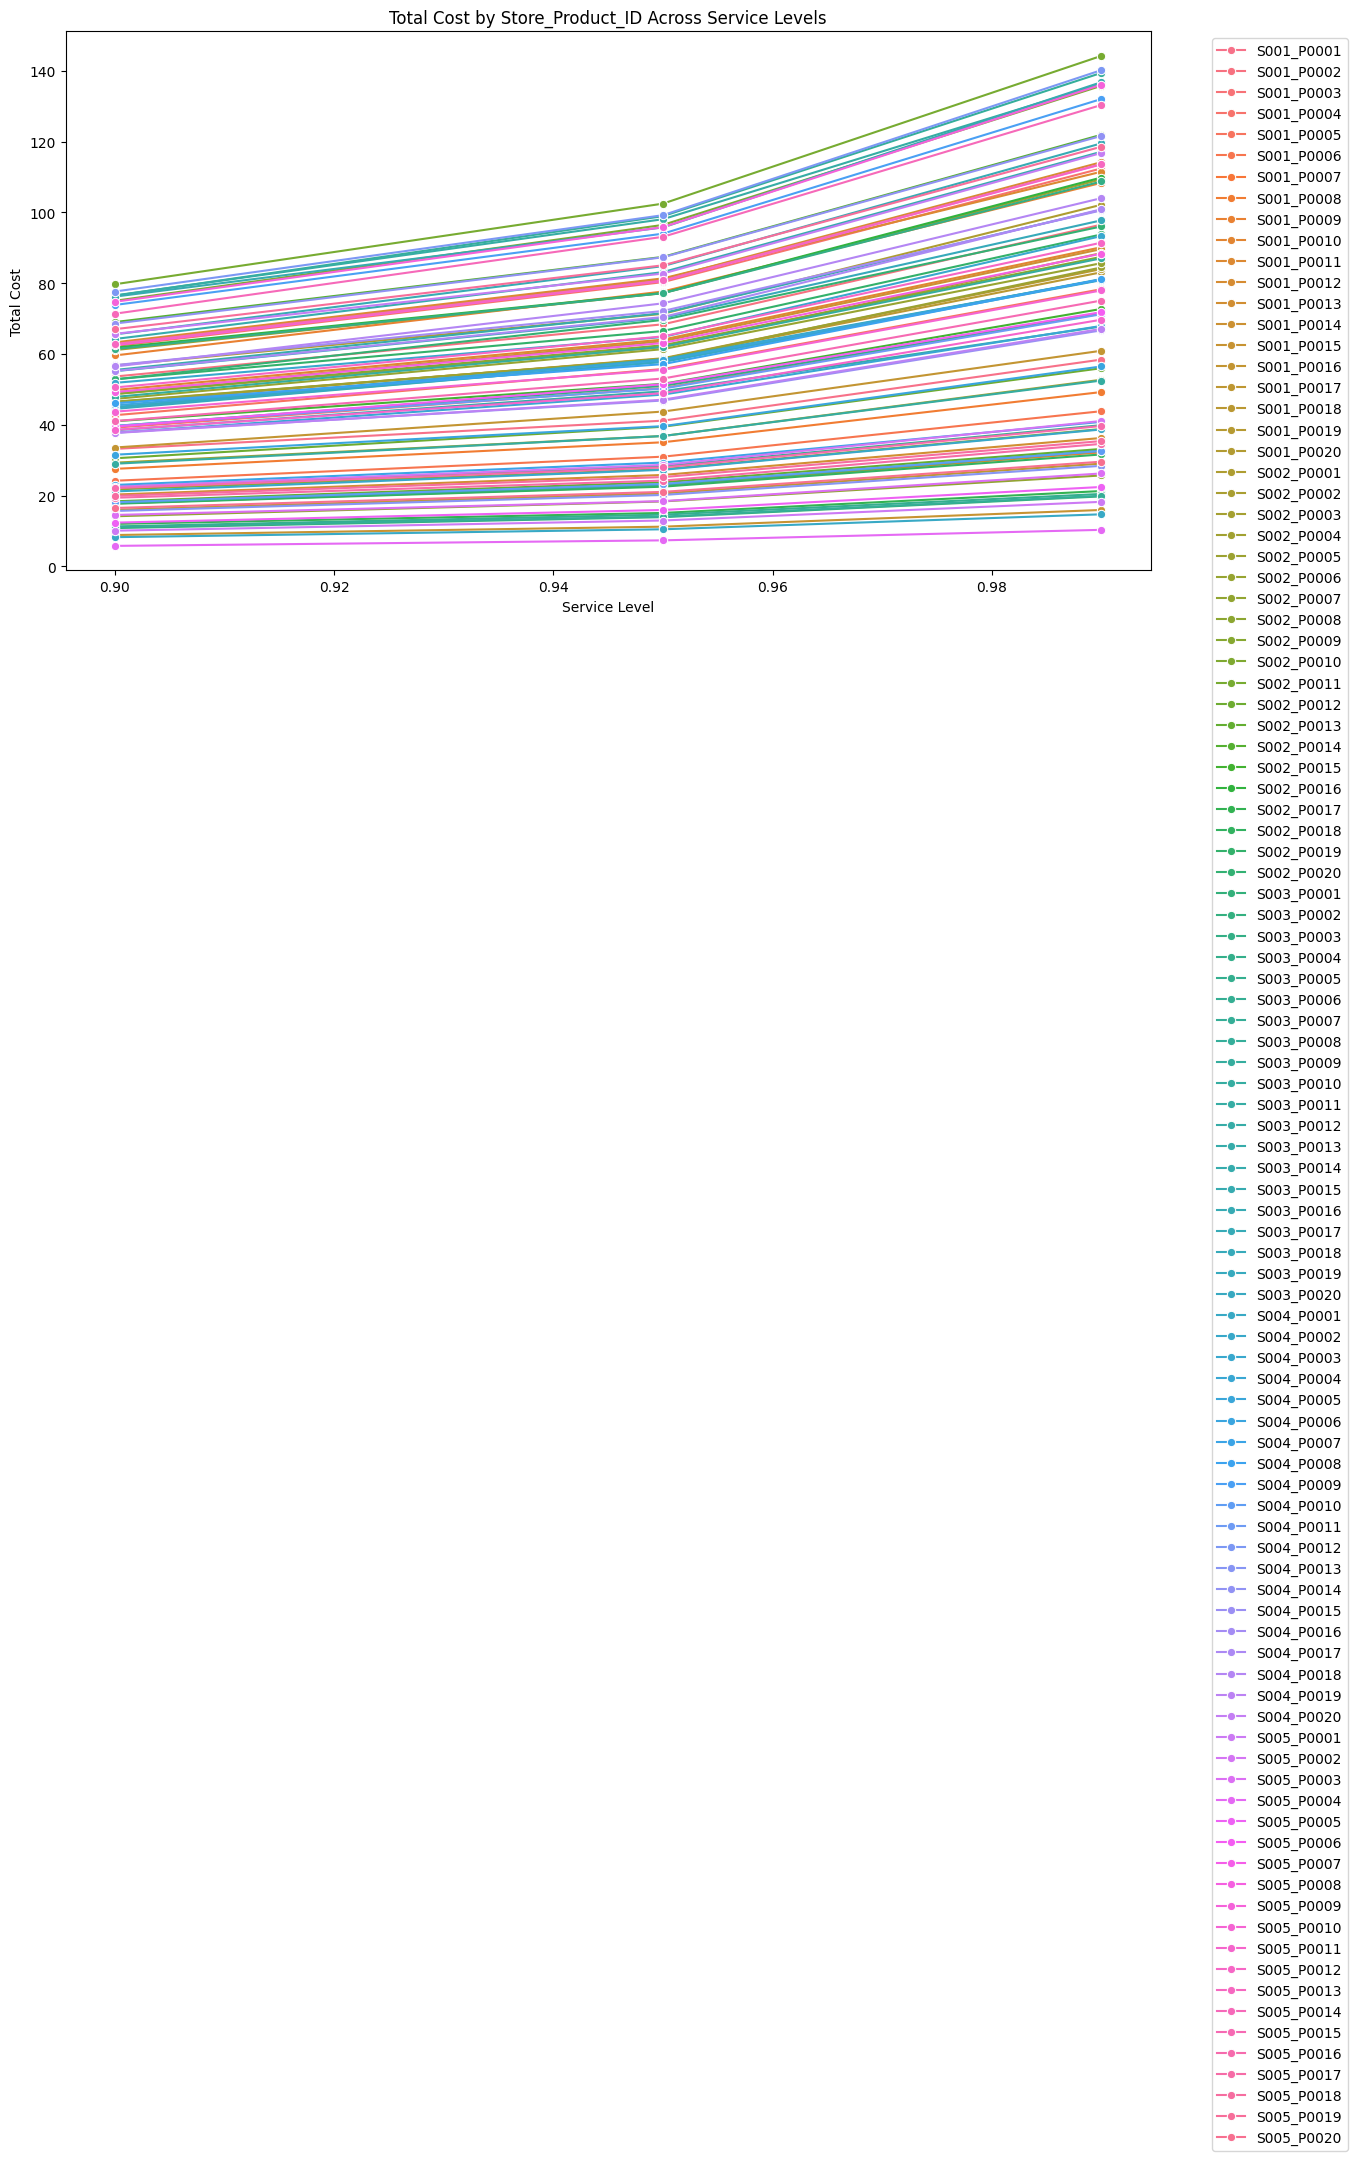

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=results_df,
    x='Service_Level',          # ✅ Correct column name
    y='Total_Cost',             # ✅ Also correct after renaming
    hue='Store_Product_ID',
    marker='o'
)

plt.title('Total Cost by Store_Product_ID Across Service Levels')
plt.ylabel('Total Cost')
plt.xlabel('Service Level')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()